# Проект определения стоимости автомобиля.  
Сервис по продаже автомобилей запускает сервис для привлечения новых клиентов. Модель должна расчитвать рыночную стоимость автомобиля в зависимости от технических характеристик и комплектации. 


In [3]:
! pip install optuna

In [1]:
import pandas as pd
import numpy as np
import datetime
import time

import matplotlib as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px 
import plotly.graph_objects as go

# from pandas_profiling import ProfileReport

from scipy import stats as st
import math as mth

from sklearn.linear_model import LinearRegression, LassoCV, Ridge
from sklearn import set_config
from sklearn.utils import shuffle
from numpy.random import RandomState
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error

from catboost import Pool, CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.2f}'.format)

[1. Загрузка данных](#data_download)  
[2. Знакомство в с данными. Предобработка](#data_preprocessing)  
[3. Выбор моделей обучения](#model_celection)  
[4. Линейные регрессии](#regressions)  
[5. Градиентный бустинг](#gradient_boosting)  
[5.1 LightGBM](#light_gbm)  
[5.2 CatBoost](#my_model)  
[6. Меняем гиперпараметры](#hyperparameters)  
[7. Выводы](#Conclusion)  


<a id='data_download'></a>
### 1. Загрузка данных


In [2]:
# загрузим данные
try: 
    data = pd.read_csv('/Users/ulia/Downloads/autos.csv')
except FileNotFoundError:
    data = pd.read_csv('/datasets/autos.csv')


    

In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<a id='#data_preprocessing'></a>
### 2. Знакомство в с данными. Предобработка

In [4]:
# получим общиее представление о датасете:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
data.isnull().sum().sort_values()

DateCrawled              0
Price                    0
RegistrationYear         0
Power                    0
Kilometer                0
RegistrationMonth        0
Brand                    0
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
Model                19705
Gearbox              19833
FuelType             32895
VehicleType          37490
NotRepaired          71154
dtype: int64

In [10]:
# ProfileReport(data)

In [11]:
# Видим, что в данных есть пропуски в столбцах VehicleType, Gearbox, Model, FuelType, NotRepaired
# необходимо проверить на дубликаты, в том числе скрытые

In [ ]:
# Посмотрим минимальные и максимальные даты в столбцах DateCrawled, RegistrationYear

In [7]:
# DataCrawled
(pd.to_datetime(data.DateCrawled).dt.year.min(),pd.to_datetime(data.DateCrawled).dt.year.max())

(2016, 2016)

In [8]:
# RegistrationYear
(data.RegistrationYear.min(), data.RegistrationYear.max())

(1000, 9999)

Для оценки предполагаемой сотимости автомобиля считаю столбцы DateCrawled, DateCreated, LastSeen, PostalCode нерелевантными, думаю для упрощения модели их можно удалить 
Удалим также столбец NumberOfPictures - в нем одни нули 


In [9]:
data = data.drop(['DateCrawled', 'DateCreated', 'LastSeen', 'PostalCode','NumberOfPictures'], axis=1)

In [8]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


In [10]:
# проверим на дубликаты
data.duplicated().sum()

27543

In [11]:
data = data.drop_duplicates()

In [12]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,326826.00,326826.00,326826.00,326826.00,326826.00
mean,4403.75,2004.23,110.24,128144.07,5.70
std,4518.21,91.12,195.89,37947.66,3.72
min,0.00,1000.00,0.00,5000.00,0.00
25%,1000.00,1999.00,69.00,125000.00,3.00
50%,2700.00,2003.00,105.00,150000.00,6.00
75%,6350.00,2008.00,141.00,150000.00,9.00
max,20000.00,9999.00,20000.00,150000.00,12.00


Text(0.5, 1.0, 'Распределение данных по годам')

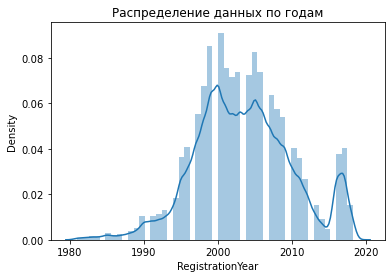

In [13]:
sns.distplot(data.query('RegistrationYear > 1980 and RegistrationYear < 2030')\
    .RegistrationYear).set_title('Распределение данных по годам')

Видим явно ошибочные значения в столбце RegistrationYear, оставим строки, где значения этого признака в промежутке от 1990 до 2016 (данные просканированы в 2016 году)

In [14]:
data = data.query('RegistrationYear >=1990 and RegistrationYear <=2016')

In [15]:
data.RegistrationMonth.value_counts(normalize=True).sort_index()

0    0.10
1    0.07
2    0.06
3    0.10
4    0.08
5    0.08
6    0.09
7    0.08
8    0.06
9    0.07
10   0.07
11   0.07
12   0.07
Name: RegistrationMonth, dtype: float64

<AxesSubplot:xlabel='RegistrationMonth', ylabel='Density'>

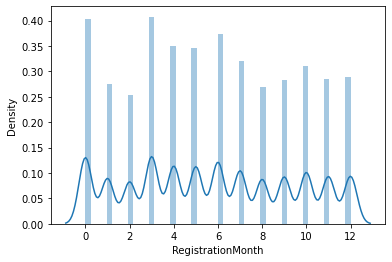

In [16]:
sns.distplot(data['RegistrationMonth'])



Очень странно, что месяцев регистрации 13, а не 12, это моджет говорить о разном кодировании дат или об ошибке, когда нулевой месяц указывает на отсутсвие данных. В данном случае нужно было бы задать вопрос поставщику данных. Я предположу, что 0 - это отсутствие данных, остальные месяца (с 1 по 12) распределю на 4 сезона:

In [17]:
def seasons(row):
    if row['RegistrationMonth'] in [12,1,2]:
        return 'winter'
    elif row['RegistrationMonth'] in [3,4,5]:
        return 'spring'
    elif row['RegistrationMonth'] in [6,7,8]:
        return 'summer'
    elif row['RegistrationMonth'] in [9,10,11]:
        return 'autumn'
    else:
        return 'no data'       

In [18]:
data['RegistrationMonth'] = data.apply(seasons, axis=1)

In [19]:
data = data.rename(columns={'RegistrationMonth':'RegSeason'})

In [20]:
data.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'RegSeason', 'FuelType', 'Brand', 'NotRepaired'],
      dtype='object')

In [21]:
# Пропуски по столбцам в процентном отношении
data.isna().mean().sort_values()

Price              0.00
RegistrationYear   0.00
Power              0.00
Kilometer          0.00
RegSeason          0.00
Brand              0.00
Gearbox            0.05
Model              0.05
VehicleType        0.07
FuelType           0.08
NotRepaired        0.19
dtype: float64

In [22]:
# petrol и  gasoline обознчим 'petrol', lpg и cng - 'gas'
data['FuelType'] = data['FuelType'].replace('gasoline','petrol').replace('lpg','gas').replace('cng','gas')

In [23]:
data['FuelType'].value_counts()

petrol      273951
gas           5212
hybrid         218
other          129
electric        86
Name: FuelType, dtype: int64

In [24]:
# После переобозначения проверим на дубликаты и удалим при необходимости
data.duplicated().sum()
data.drop_duplicates()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegSeason,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,no data,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,spring,petrol,audi,yes
2,9800,suv,2004,auto,163,grand,125000,summer,petrol,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,summer,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,summer,petrol,skoda,no
...,...,...,...,...,...,...,...,...,...,...,...
354364,0,NaN,2005,manual,0,colt,150000,summer,petrol,mitsubishi,yes
354365,2200,NaN,2005,NaN,0,NaN,20000,winter,NaN,sonstige_autos,NaN
354366,1199,convertible,2000,auto,101,fortwo,125000,spring,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,spring,petrol,volkswagen,no


In [25]:
data.isna().sum().sort_values()

Price                   0
RegistrationYear        0
Power                   0
Kilometer               0
RegSeason               0
Brand                   0
Gearbox             14383
Model               15027
VehicleType         20448
FuelType            24153
NotRepaired         57487
dtype: int64

In [26]:
# пропущенные значения в столбце NotRepaired заполним строкой 'no data'
data['NotRepaired'] = data['NotRepaired'].fillna('no data')

Заполним пропуски в столбцах VehicleType  и FuelType так: сгруппируем данные по модели, заполним пропуски наиболее часто встречающимися значениями (mode)

In [27]:
mode_vtypes = dict(data.groupby('Model')['VehicleType'].apply(lambda x: st.mode(x)[0][0]))

In [28]:
mode_fueltypes = dict(data.groupby('Model')['FuelType'].apply(lambda x: st.mode(x)[0][0]))

In [29]:
for key, value in mode_vtypes.items():
    data.loc[(data['VehicleType'].isna())&(data['Model']==key),'VehicleType'] = value 
    

In [30]:
for key, value in mode_fueltypes.items():
    data.loc[(data['FuelType'].isna())&(data['Model']==key),'FuelType'] = value 
    

In [31]:
data.isna().mean().sort_values()

Price              0.00
RegistrationYear   0.00
Power              0.00
Kilometer          0.00
RegSeason          0.00
Brand              0.00
NotRepaired        0.00
VehicleType        0.01
FuelType           0.02
Gearbox            0.05
Model              0.05
dtype: float64

In [32]:
data.groupby(['Brand','VehicleType','RegistrationYear']).agg({'Model':'nunique'})

Model
Brand      VehicleType RegistrationYear       
alfa_romeo convertible 1990                  1
                       1991                  1
                       1992                  1
                       1993                  1
                       1995                  1
...                                        ...
volvo      wagon       2011                  4
                       2012                  4
                       2013                  2
                       2014                  1
                       2016                  4

[4979 rows x 1 columns]

Видим, что заполнить модели по данным производителя, типа машины и года выпуска не получится, нет однозначного соответствия, так как модель очень сильно влияент на цену, лучше пропуски удалить, чем пытаться их заполнить. И поскольку пропуски в каждом столбце не превышают 5%, считаю правильным все оставшиеся с в данных пропуски удалить

In [33]:
data = data.dropna()

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 277023 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             277023 non-null  int64 
 1   VehicleType       277023 non-null  object
 2   RegistrationYear  277023 non-null  int64 
 3   Gearbox           277023 non-null  object
 4   Power             277023 non-null  int64 
 5   Model             277023 non-null  object
 6   Kilometer         277023 non-null  int64 
 7   RegSeason         277023 non-null  object
 8   FuelType          277023 non-null  object
 9   Brand             277023 non-null  object
 10  NotRepaired       277023 non-null  object
dtypes: int64(4), object(7)
memory usage: 25.4+ MB


Рассмотрим столбец Power

In [35]:
data.Power.describe()

count   277023.00
mean       116.01
std        186.85
min          0.00
25%         75.00
50%        107.00
75%        144.00
max      20000.00
Name: Power, dtype: float64

Мощность серийных машин не превышает 1850 лс 
[ссылка](https://atlanticexpress.com.ua/samye-moshhnye-serijnye-avto-v-mire-ot-1750-l-s/)  

Удалим выбросы:

In [36]:
data = data.query('Power<=1850')

In [37]:
data.Power.describe()

count   276918.00
mean       113.24
std         66.62
min          0.00
25%         75.00
50%        107.00
75%        144.00
max       1800.00
Name: Power, dtype: float64

In [42]:
# Нули в столбце Power скорее всего означают пропуски. 

In [38]:
# У 90 процентов данных мощность выше 54 лс, заменим значения меньшие 54 на медианные по модели
data.Power.quantile(0.1)

54.0

In [39]:
median_power = dict(data.groupby('Model')['Power'].apply(lambda x: x.median()))

In [40]:
for key, value in median_power.items():
    data.loc[(data['Power']<54)&(data['Model']==key),'Power'] = value 

In [41]:
data.Power.describe()

count   276918.00
mean       121.24
std         59.37
min          0.00
25%         80.00
50%        112.00
75%        150.00
max       1800.00
Name: Power, dtype: float64

In [42]:
data[data['Power']==0]['Model'].unique()

array(['samara'], dtype=object)

Мощность Lada Samara составляет в основном 70-80 лс [источник Википедия](https://ru.wikipedia.org/wiki/Lada_Samara#:~:text=Lada%20Samara%20%E2%80%94%20%D1%81%D0%B5%D0%BC%D0%B5%D0%B9%D1%81%D1%82%D0%B2%D0%BE%20%D1%81%D0%BE%D0%B2%D0%B5%D1%82%D1%81%D0%BA%D0%B8%D1%85%20%D0%B8,%D1%81%D0%BE%D0%B1%D0%BE%D0%B9%20%D0%B2%D1%82%D0%BE%D1%80%D0%BE%D0%B5%20%D0%BF%D0%BE%D0%BA%D0%BE%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5%20%D0%B0%D0%B2%D1%82%D0%BE%D0%BC%D0%BE%D0%B1%D0%B8%D0%BB%D0%B5%D0%B9%20%D0%92%D0%90%D0%97.)  
Заполним занчения равные 0, значением 80 лс

In [43]:
data.loc[data['Power']==0, 'Power'] = 80

In [44]:
data.Power.describe()

count   276918.00
mean       121.24
std         59.37
min         26.00
25%         80.00
50%        112.00
75%        150.00
max       1800.00
Name: Power, dtype: float64

Завершена предобработка данных:  
1) Удалены столбцы, не влияющие на цены  
2) Удалены дубликаты  
3) Обработаны и заполнены пропуски  
#### Данные готовы для обучения

<a id='model_celection'></a>
### 3. Выбор моделей обучения. Подготовка данных

Применим модели Линейной Регресси, CatBoost, LightGBM  
Линейная регрессия не умеет работать с категориальными переменными. Нужно будет их закодировать.

In [45]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegSeason,FuelType,Brand,NotRepaired
0,480,sedan,1993,manual,101.00,golf,150000,no data,petrol,volkswagen,no data
2,9800,suv,2004,auto,163.00,grand,125000,summer,petrol,jeep,no data
3,1500,small,2001,manual,75.00,golf,150000,summer,petrol,volkswagen,no
4,3600,small,2008,manual,69.00,fabia,90000,summer,petrol,skoda,no
5,650,sedan,1995,manual,102.00,3er,150000,autumn,petrol,bmw,yes


In [46]:
# категориальные переменные
cat_columns = ['VehicleType','Gearbox','Model','RegSeason','FuelType','RegistrationYear','Brand','NotRepaired']

In [47]:
data.RegistrationYear.sort_values().unique()

array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016])

Годы идут без пропусков, можно считать год регистрации категориальным признаком

In [48]:
# кодируем
data_encorded = pd.get_dummies(data, columns = cat_columns, drop_first=True)

In [49]:
data_encorded.head()

,Price,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,...,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_no data,NotRepaired_yes
0,480,101.00,150000,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2,9800,163.00,125000,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,1500,75.00,150000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,3600,69.00,90000,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
5,650,102.00,150000,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Разделим выборки на тренировочную, валидационную и тестовую

In [50]:
features = data_encorded.drop('Price', axis=1)
target = data_encorded['Price']

In [51]:
features_train_full, features_test, target_train_full, target_test = train_test_split(features,\
    target, test_size=0.2, random_state = 123123)
[data.shape[0], features_train_full.shape[0],features_test.shape[0]]

[276918, 221534, 55384]

In [52]:
features_train, features_valid, target_train, target_valid = train_test_split(features_train_full,\
     target_train_full,test_size=0.25, random_state=123123)
[features_train_full.shape[0], features_train.shape[0],features_valid.shape[0]]

[221534, 166150, 55384]

In [53]:
#  стандартизируем численные признаки:
scaler = StandardScaler()
numeric = ['Kilometer','Power']
features_train[numeric] = scaler.fit_transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [54]:
# Линейная регрессия
start = time.time()
model = LinearRegression()
model.fit(features_train, target_train)
end = time.time()
Linear_time = end - start
print(Linear_time)

6.29614520072937


In [55]:
prediction = model.predict(features_valid)

In [56]:
RMSE_reg = np.sqrt(((prediction - target_valid)**2).mean())
RMSE_N_reg = mean_squared_error(prediction, target_valid, squared=False)
print('RMSE по линейной регрессии {:.2f}'.format(RMSE_reg))
print('RMSE' , RMSE_N_reg)

RMSE по линейной регрессии 2160.00
RMSE 2160.004565553684


Попробуем Lasso и Ridge

In [57]:
start = time.time()
model = LassoCV(random_state=123)
model.fit(features_train, target_train)
prediction_lasso = model.predict(features_valid)
end = time.time()
Lasso_time = end - start

In [58]:
RMSE_lasso = mean_squared_error(prediction_lasso, target_valid, squared=False)
print('RMSE по Lasso  {:.2f}'.format(RMSE_lasso))

RMSE по Lasso  2228.29


In [59]:
start = time.time()
model = Ridge(random_state=123)
model.fit(features_train, target_train)
prediction_ridge = model.predict(features_valid)
end = time.time()
Ridge_time = end - start

In [60]:
RMSE_ridge = mean_squared_error(prediction_ridge,target_valid, squared=False)
print('RMSE по Ridge  {:.2f}'.format(RMSE_ridge))

RMSE по Ridge  2160.45


Все модели линейной регрессии показали очень хорошие результаты, лучше трешхолда в 2500 

<a id='gradient_boosting'></a>
### 5. Градиентный бустинг

<a id='light_gbm'></a>
### 5.1 LightGBM

In [61]:
data[cat_columns] = data[cat_columns].astype('category')


In [62]:
features_light = data.drop('Price', axis=1)
target_light = data['Price']

In [63]:
features_light_train, features_light_test, target_light_train, target_light_test = train_test_split(features_light, target_light,test_size=0.25, random_state=123)

In [64]:
features_light_train_full, features_light_test, target_light_train_full, target_light_test = train_test_split(features_light,\
    target_light, test_size=0.2, random_state = 123123)
[data.shape[0], features_train_full.shape[0],features_test.shape[0]]

[276918, 221534, 55384]

In [65]:
features_light_train, features_light_valid, target_light_train, target_light_valid = train_test_split(features_light_train_full,\
     target_light_train_full,test_size=0.25, random_state=123123)
[features_train_full.shape[0], features_train.shape[0],features_valid.shape[0]]

[221534, 166150, 55384]

In [66]:
%%time
start_light = time.time()
light = lgb.LGBMRegressor()
light.fit(features_light_train, target_light_train, eval_set=[(features_light_valid, target_light_valid)],\
     eval_metric='rmse', categorical_feature=cat_columns)
end_light = time.time()
Light_time = end_light - start_light
print(Light_time)


[1]	valid_0's rmse: 4258.43	valid_0's l2: 1.81342e+07
[2]	valid_0's rmse: 3958.13	valid_0's l2: 1.56668e+07
[3]	valid_0's rmse: 3688.75	valid_0's l2: 1.36069e+07
[4]	valid_0's rmse: 3450.04	valid_0's l2: 1.19028e+07
[5]	valid_0's rmse: 3242.4	valid_0's l2: 1.05132e+07
[6]	valid_0's rmse: 3058.3	valid_0's l2: 9.35319e+06
[7]	valid_0's rmse: 2896.15	valid_0's l2: 8.38771e+06
[8]	valid_0's rmse: 2753.93	valid_0's l2: 7.58412e+06
[9]	valid_0's rmse: 2627.35	valid_0's l2: 6.90295e+06
[10]	valid_0's rmse: 2515.56	valid_0's l2: 6.32806e+06
[11]	valid_0's rmse: 2417.83	valid_0's l2: 5.84591e+06
[12]	valid_0's rmse: 2330.89	valid_0's l2: 5.43306e+06
[13]	valid_0's rmse: 2255.37	valid_0's l2: 5.08669e+06
[14]	valid_0's rmse: 2188.03	valid_0's l2: 4.78749e+06
[15]	valid_0's rmse: 2129.73	valid_0's l2: 4.53576e+06
[16]	valid_0's rmse: 2076.82	valid_0's l2: 4.31318e+06
[17]	valid_0's rmse: 2032.06	valid_0's l2: 4.12928e+06
[18]	valid_0's rmse: 1993.06	valid_0's l2: 3.97227e+06
[19]	valid_0's rmse: 

In [67]:
predictions_light = light.predict(features_light_valid, num_iteraction=light.best_iteration_)
RMSE_light = mean_squared_error(predictions_light, target_light_valid,squared=False)

In [68]:
print('RMSE по LightGBM {:.2f}'.format(RMSE_light))


RMSE по LightGBM 1624.07


<a id='my_model'></a>
### 5.2 CatBoost

In [69]:
model_cat = CatBoostRegressor(cat_features=cat_columns)

In [70]:
%%time
start_cat = time.time()
model_cat.fit(features_light_train, target_light_train, eval_set=(features_light_valid, target_light_valid), verbose=200)
end_cat = time.time()
Cat_time = end_cat-start_cat

Learning rate set to 0.113636
0:	learn: 4229.1668294	test: 4242.3184621	best: 4242.3184621 (0)	total: 170ms	remaining: 2m 49s
200:	learn: 1655.1211457	test: 1687.4167260	best: 1687.4167260 (200)	total: 25.6s	remaining: 1m 41s
400:	learn: 1599.9892994	test: 1651.9537277	best: 1651.9537277 (400)	total: 51.2s	remaining: 1m 16s
600:	learn: 1567.6392891	test: 1633.8739149	best: 1633.8739149 (600)	total: 1m 17s	remaining: 51.6s
800:	learn: 1544.1806973	test: 1623.5272147	best: 1623.5272147 (800)	total: 1m 43s	remaining: 25.8s
999:	learn: 1527.1856920	test: 1618.1490654	best: 1618.1490654 (999)	total: 2m 6s	remaining: 0us

bestTest = 1618.149065
bestIteration = 999

CPU times: user 4min 12s, sys: 5.79 s, total: 4min 18s
Wall time: 2min 7s


In [71]:
predictions_cat = model_cat.predict(features_light_valid)

In [72]:
RMSE_cat = mean_squared_error(predictions_cat, target_light_valid, squared=False)

In [73]:
print('RMSE по CatBoost {:.2f}'.format(RMSE_cat))

RMSE по CatBoost 1618.15


In [74]:
scores = [RMSE_reg, RMSE_light, RMSE_cat, RMSE_lasso, RMSE_ridge]
times = [Linear_time, Light_time, Cat_time, Lasso_time, Ridge_time]
models = ['LinearRegression', 'LightGBM','CatBoostRegressor', 'Lasso','Ridge']
table = pd.DataFrame({'model':models,'score_rmse':scores,'time_sec':times})

In [75]:
table.sort_values(by='score_rmse').reset_index(drop=True)

,model,score_rmse,time_sec
0,CatBoostRegressor,1618.15,127.69
1,LightGBM,1624.07,2.25
2,LinearRegression,2160.00,6.30
3,Ridge,2160.45,1.19
4,Lasso,2228.29,34.85


Применив методы "из коробки", без настойки гиперпараметров, мы получили результаты удовлетворяющие нашим условиям (RMSE меньше 2500) для всех моделей.  
При этом лучшие результаты показала модель Catboost, а быстрее всех отработала модель Ridge Regression

<a id='hyperparameters'></a>
### 6 Меняем гиперпараметры

In [76]:
#Ridge regression
start = time.time()
model_reg = Ridge(random_state=123)
params = {'alpha': np.arange(0,3,0.05), 'fit_intercept':[True,False]}
grid_reg = GridSearchCV(model_reg,params, scoring='neg_root_mean_squared_error')
grid_reg.fit(features_train,target_train)
predict_reg = grid_reg.predict(features_valid)
end = time.time()
Ridge_param_time = end - start
RMSE_reg_params = mean_squared_error(predict_reg, target_valid, squared=False)


In [77]:
grid_reg.best_params_

{'alpha': 0.05, 'fit_intercept': True}

In [78]:
print('RMSE по Ridge {:.2f}'.format(RMSE_reg_params))


RMSE по Ridge 2160.00


Значение RMSE практически не изменилось

In [79]:
#LightGBM
# попробуем применить optuna
start = time.time() 
from optuna.integration import LightGBMPruningCallback
def objective(trial):
    param_grid = { 
        "n_estimators": trial.suggest_categorical("n_estimators", [100]),
        "num_leaves": trial.suggest_int("num_leaves", 20, 200, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12)
        }
    dtrain = lgb.Dataset(features_light_train, label=target_light_train)
    gbm = lgb.train(param_grid, dtrain)
    preds = gbm.predict(features_light_valid)
    pred_labels = np.rint(preds)
    rmse =  mean_squared_error(preds, target_light_valid, squared=False)
    return rmse


if __name__ == "__main__":
    study = optuna.create_study(direction= 'minimize')
    study.optimize(objective, n_trials=100)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    

end = time.time()
Light_param_time = end - start

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 604
[LightGBM] [Info] Number of data points in the train set: 166150, number of used features: 10
[LightGBM] [Info] Start training from score 4625.751267
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 604
[LightGBM] [Info] Number o

In [80]:
#CatBoost
# попробуем применить optuna
start = time.time()
def objective(trial):
    param_grid = { 
        "depth": trial.suggest_int("max_depth", 3, 12),
        'min_child_samples': trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])
        }
    model_cat = CatBoostRegressor(cat_features=cat_columns, **param_grid)
    model_cat.fit(features_light_train, target_light_train, eval_set=(features_light_valid, target_light_valid), verbose=200)
    predictions = model_cat.predict(features_light_valid)
    rmse =  mean_squared_error(predictions,target_light_valid, squared=False)
    return rmse


if __name__ == "__main__":
    study = optuna.create_study(direction= 'minimize')
    study.optimize(objective, n_trials=10)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

end  = time.time()
Cat_param_time = end - start

Learning rate set to 0.113636
0:	learn: 4269.4695416	test: 4282.9457541	best: 4282.9457541 (0)	total: 72.4ms	remaining: 1m 12s
200:	learn: 1794.6032449	test: 1800.4061040	best: 1800.4061040 (200)	total: 10.8s	remaining: 43.1s
400:	learn: 1733.7756574	test: 1742.0911104	best: 1742.0911104 (400)	total: 17.7s	remaining: 26.4s
600:	learn: 1706.7716600	test: 1718.3867134	best: 1718.3867134 (600)	total: 24.6s	remaining: 16.3s
800:	learn: 1690.0932132	test: 1705.9405417	best: 1705.9405417 (800)	total: 31.7s	remaining: 7.88s
999:	learn: 1677.1140903	test: 1697.1032969	best: 1697.1032969 (999)	total: 40.1s	remaining: 0us

bestTest = 1697.103297
bestIteration = 999

Learning rate set to 0.113636
0:	learn: 4185.5418243	test: 4199.7584060	best: 4199.7584060 (0)	total: 236ms	remaining: 3m 55s
200:	learn: 1392.5919641	test: 1604.1296660	best: 1604.0965567 (199)	total: 1m 7s	remaining: 4m 28s
400:	learn: 1257.3076258	test: 1588.2733941	best: 1588.2733941 (400)	total: 2m 11s	remaining: 3m 17s
600:	lea

In [81]:
# Проверим лучшие модели  на тестовых данных:
# Ridge 
start_train_ridge = time.time()
model_ridge = Ridge(alpha=0.05, fit_intercept=True)
model_ridge.fit(features_train, target_train)
end_train_ridge = time.time()
Time_ridge_train = end_train_ridge - start_train_ridge


In [83]:
start_predict_ridge = time.time()
prediction_ridge_test = model_ridge.predict(features_test)
end_predict_ridge = time.time()
Time_ridge_pred = end_predict_ridge - start_predict_ridge
rmse_ridge_test = mean_squared_error(prediction_ridge_test, target_test, squared=False)
print('RMSE Ridge на тестовой выборке составляет {:.2f}'.format(rmse_ridge_test))

RMSE Ridge на тестовой выборке составляет 2125.77


In [84]:
#LightGBM
dtrain = lgb.Dataset(features_light_train, label=target_light_train)
start_train_light = time.time()
model_light_test = lgb.LGBMRegressor(n_estimators=100, num_leaves=200, max_depth=12)
model_light_test.fit(features_light_train, target_light_train)
end_train_light = time.time()
Time_light_train = end_train_light - start_train_light

In [85]:
start_predict_light = time.time()
prediction_light_test = model_light_test.predict(features_light_test)
end_predict_light = time.time()
Time_light_pred = end_predict_light - start_predict_light
rmse_light_test = mean_squared_error(prediction_light_test, target_light_test, squared=False)
print('RMSE LightGBM на тестовой выборке составляет {:.2f}'.format(rmse_light_test))

RMSE LightGBM на тестовой выборке составляет 1584.67


In [86]:
#CatBoost
start_train_cat = time.time()
model_cat_test = CatBoostRegressor(cat_features=cat_columns, max_depth=10, min_child_samples=16)
model_cat_test.fit(features_light_train, target_light_train)
end_train_cat = time.time()
Time_cat_train = end_train_cat - start_train_cat

Learning rate set to 0.091837
0:	learn: 4269.6676080	total: 290ms	remaining: 4m 49s
1:	learn: 3985.5270322	total: 493ms	remaining: 4m 6s
2:	learn: 3732.7016584	total: 850ms	remaining: 4m 42s
3:	learn: 3502.4438622	total: 1.22s	remaining: 5m 3s
4:	learn: 3302.6562538	total: 1.55s	remaining: 5m 7s
5:	learn: 3125.2377079	total: 1.79s	remaining: 4m 57s
6:	learn: 2961.8988328	total: 2.12s	remaining: 5m
7:	learn: 2817.4021704	total: 2.36s	remaining: 4m 53s
8:	learn: 2691.9455448	total: 2.78s	remaining: 5m 6s
9:	learn: 2578.8506992	total: 3.02s	remaining: 4m 58s
10:	learn: 2479.4922498	total: 3.3s	remaining: 4m 56s
11:	learn: 2391.8037499	total: 3.64s	remaining: 4m 59s
12:	learn: 2312.8504487	total: 3.96s	remaining: 5m
13:	learn: 2241.8606355	total: 4.31s	remaining: 5m 3s
14:	learn: 2181.4616071	total: 4.57s	remaining: 4m 59s
15:	learn: 2126.4781945	total: 4.79s	remaining: 4m 54s
16:	learn: 2079.3821358	total: 5.1s	remaining: 4m 54s
17:	learn: 2036.7337943	total: 5.28s	remaining: 4m 48s
18:	l

In [87]:
start_predict_cat = time.time()
prediction_cat_test = model_cat_test.predict(features_light_test)
end_predict_cat = time.time()
Time_cat_pred = end_predict_cat - start_predict_cat
rmse_cat_test = mean_squared_error(prediction_cat_test, target_light_test, squared=False)
print('RMSE CatBoost на тестовой выборке составляет {:.2f}'.format(rmse_light_test))

RMSE CatBoost на тестовой выборке составляет 1584.67


In [88]:
scores_final = [rmse_ridge_test, rmse_light_test, rmse_cat_test]
learing_times = [Time_ridge_train, Time_light_train, Time_cat_train]
predicting_times = [Time_ridge_pred, Time_light_pred, Time_cat_pred]
models = ['Ridge', 'LightGBM','CatBoostRegressor']
final_table = pd.DataFrame({'model':models,'score_final':scores_final,'train_time_sec':learing_times, 'pred_time_sec':predicting_times})

In [89]:
final_table.sort_values(by='score_final')

,model,score_final,train_time_sec,pred_time_sec
2,CatBoostRegressor,1583.09,268.24,0.86
1,LightGBM,1584.67,2.87,0.46
0,Ridge,2125.77,1.20,0.13


<a id = 'Conclusion'></a>
### 7. Выводы

### Провели работу по предсказанию цены на подержанные автомобили:  
1. Подготовли данные для анализа:
    - удалили нерелевантные столбцы  
    - заполнили пропуски  
    - удалили дубликаты  
2. Подготвили данные для построения моделей:
    - применили кодирование категориальных переменных  
    - произвели нормирование численных переменных  
3. Построили модели Линейной регрессии, Lasso, Ridge, LightGBM, CatBoost из коробки - без настройки гиперпараметров  
    - все модели показали очень хороший результат
    - лучше всего показала себя модель CatBoost, RMSE = 1618  
    - Самой быстрой оказалась модель Ridge  
4.  Настраивали модели, меняя гиперпараметры. Для экономии времени, меняли ограниченное количество параметров, те результаты могли бы быть еще лучше  
    - Модель Ridge регрессии не улучшила предсказания  
    - Для модели LightGBM удалось добиться RMSE = 1576, при следующих параметрах: 
        -- n_estimators: 100
        -- num_leaves: 200
        -- max_depth: 12  
    - Модель CatBoost показала результат RMSE = 1584  
    Params:   
        -- max_depth: 10 
        -- min_child_samples: 12  
5. На тестовой выборке  лучше всех показала себя модель Catboost и LightGBM, LightGBM показала также очень низкое время обучения  
Для использования стоит применить модель LightGBM, у нее очень высокие показатели предсказаний и низкое время обучения, модель Catboost показывает сходное с LightGBM качество предсказаний, но вот обучается модель намного медленнее  